## Import your stuff

In [1]:
import numpy as np
import simulators.jla_supernovae.jla_simulator as jla
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import pydelfi.score as score
import pydelfi.priors as priors
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [2]:
import pylab as plt
import pyccl as ccl
import scipy
from scipy.interpolate import interp1d

import matplotlib
%matplotlib inline

import time
import importlib

print("CCL version you are using:",ccl.__version__)

CCL version you are using: 2.1.0


In [3]:
font_config = {"size" : 10,
               "family" : "serif"}

matplotlib.rc("font", **font_config)
matplotlib.rc("text", usetex=True)
# Move title to make space for exponents of y axis
matplotlib.rc("axes", titlepad=5) 
matplotlib.rc("axes", titlesize="medium") 

# Make the figures bigger in the notebook
matplotlib.rc("figure", dpi=150)

color_map = plt.get_cmap("tab10")

paper_textwidth = 7.125
fig_size = (paper_textwidth/2, 2.6)

plot_adjust = dict(left=0.2, top=0.9, bottom=0.2)

In [4]:
import simulators.mass_function_n_counts.simulator_trapz_2 as n_counts_simulator
importlib.reload(n_counts_simulator)

<module 'simulators.mass_function_n_counts.simulator_trapz_2' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_2.py'>

## Set up priors on params of interest (for now): {$\Omega_{m}h^{2} = \Omega_{cdm}h^{2} + \Omega_{b}h^{2}$, $\sigma_{8}$, $h$, $n_{s}$, $w_{0}$}

In [5]:
lower = np.array([0.1125, 0.020, 0.6, 0.55, 0.94, -2.50])
upper = np.array([0.1275, 0.024, 1.1, 0.90, 1.00, -0.33])
prior = priors.Uniform(lower, upper)

In [6]:
theta_fiducial = np.array([0.1197, 0.02222, 0.76, 0.69, 0.9655, -1])


## Set up the simulator
This must have the signature `simulator(parameters, seed, args, batch)` -> `np.array([batch, ndata])`

In [20]:
importlib.reload(n_counts_simulator)

<module 'simulators.mass_function_n_counts.simulator_trapz_2' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_2.py'>

In [21]:
N_countsSimulator = n_counts_simulator.Model()



In [22]:
N_countsSimulator.N_counts

array([1.78484613e+04, 5.76969893e+04, 7.91958165e+04, 7.60278893e+04,
       5.88511940e+04, 2.53148842e+03, 6.50855639e+03, 6.79903632e+03,
       4.77688556e+03, 2.60820123e+03, 1.41327071e+02, 2.40973371e+02,
       1.54407289e+02, 6.19683804e+01, 1.80223466e+01, 1.15793270e+00,
       8.97133179e-01, 2.22000351e-01, 2.95440371e-02, 2.45071739e-03])

In [23]:
log10masses = np.linspace(14, 16, num = 5)
z_min = np.linspace(0.1, 0.9, num = 5)
z_max = np.linspace(0.2, 1.0, num = 5)

In [24]:
N_countsSimulator.n_counts_trapz(theta_fiducial, 0.1, 0.2, 14.0, 14.5)

computing cosmo: 0.00019108899999942253 s
computing halo mass function object: 0.13621009199999978 s
computing factors: 0.12272163899999988 s
loop over z_steps: 0.03845153400000001 s


17848.555764027973

In [25]:
N_countsSimulator.n_counts_trapz_all(theta_fiducial, z_min, z_max, log10masses)

0
1
2
3
total: 1.007133917 s


array([1.78485558e+04, 5.76970955e+04, 7.91959673e+04, 7.60280551e+04,
       5.88513395e+04, 2.53149917e+03, 6.50857065e+03, 6.79905624e+03,
       4.77690342e+03, 2.60821304e+03, 1.41326957e+02, 2.40973379e+02,
       1.54407659e+02, 6.19686706e+01, 1.80224732e+01, 1.15792928e+00,
       8.97137339e-01, 2.22002922e-01, 2.95445872e-02, 2.45078214e-03])

In [26]:
N_countsSimulator.N_counts.shape

(20,)

In [27]:
def simulator(theta, seed, simulator_args, batch):
    return N_countsSimulator.simulation(theta, seed)

simulator_args = None

## Set up fake compressor for now

In [28]:
def compressor(data, compressor_args):
    return data
compressor_args=None

## Load data

In [29]:
N_counts_data = np.load('N_counts_random_data.npy')
N_counts_data

array([[17720, 57628, 78955, 75947, 58462],
       [ 2499,  6606,  6684,  4733,  2579],
       [  140,   228,   173,    55,    15],
       [    1,     0,     0,     1,     0]])

## Define ensemble of NDEs

In [30]:
NDEs1 = [ndes.MixtureDensityNetwork(n_parameters=6, n_data=20, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=0),
       ndes.MixtureDensityNetwork(n_parameters=6, n_data=20, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
       ndes.MixtureDensityNetwork(n_parameters=6, n_data=20, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
       ndes.MixtureDensityNetwork(n_parameters=6, n_data=20, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
       ndes.MixtureDensityNetwork(n_parameters=6, n_data=20, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
       ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=6, n_data=20, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=5)]

## Create DELFI object

In [31]:
DelfiEnsemble = delfi.Delfi(N_counts_data.reshape(20), prior, NDEs1, 
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['\\Omega_{cdm}h^{2}', '\\Omega_{b}h^{2}', '\\sigma_{8}', 'h', 'n_{s}', 'w_{0}'],
                            results_dir = "simulators/mass_function_n_counts/results/")

## Sequential Neural Likelihood

In [32]:
n_initial = 5 #200
n_batch = 5 #200
n_populations = 10 #20

0
1
2
3
total: 1.0152357200000015 s
0
1
2
3
total: 1.0144081209999989 s
0
1
2
3
total: 1.0216818589999974 s
0
1
2
3
total: 1.0120721889999977 s
0
1
2
3
total: 1.0205157929999977 s



Population 1/10
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


0
1
2
3
total: 1.0450294960000122 s
0
1
2
3
total: 1.0383963569999963 s
0
1
2
3
total: 1.0399427830000008 s
0
1
2
3
total: 1.0391714080000014 s
0
1
2
3
total: 1.0350416359999883 s


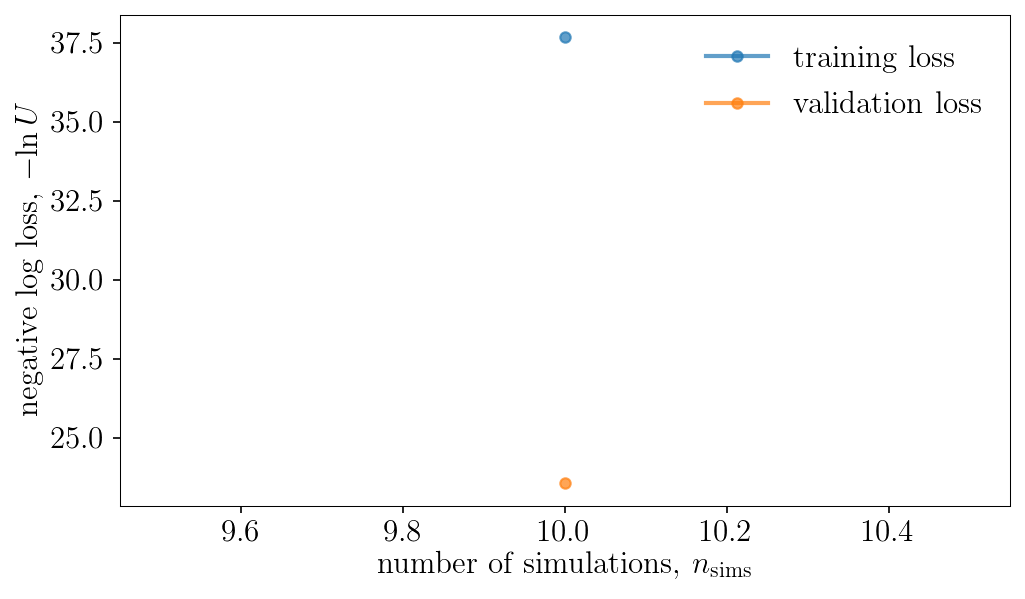

Population 2/10
Sampling proposal density...
Done.


0
1
2
3
total: 1.0220488980000084 s
0
1
2
3
total: 1.0116501900000117 s
0
1
2
3
total: 1.013143264000007 s
0
1
2
3
total: 1.0161065259999873 s
0
1
2
3
total: 1.0051428209999926 s



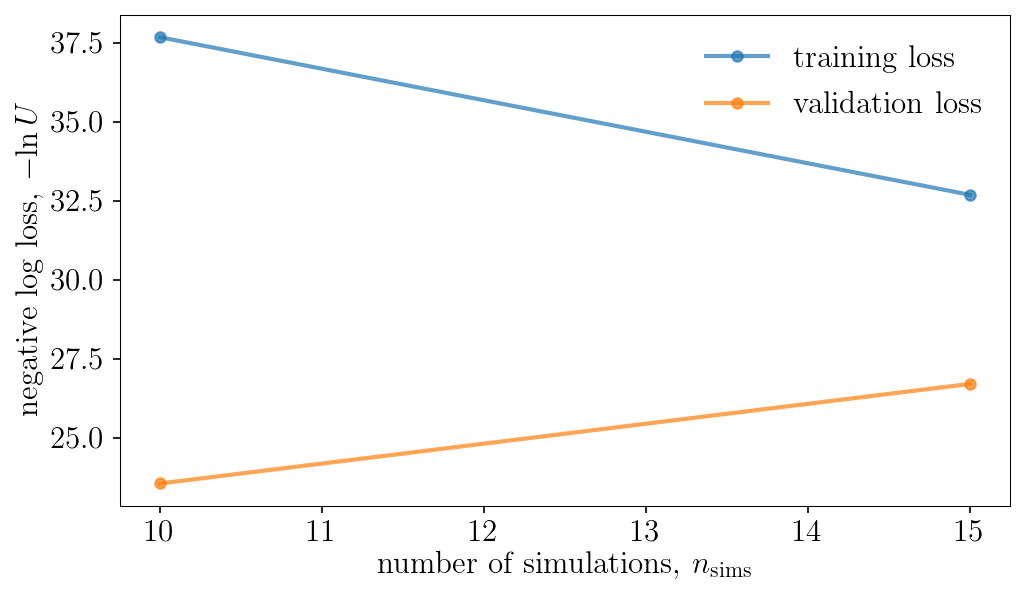

Population 3/10
Sampling proposal density...
Done.


0
1
2
3
total: 1.0266806490000135 s
0
1
2
3
total: 1.0246896240000183 s
0
1
2
3
total: 1.0170218989999853 s
0
1
2
3
total: 1.0153835589999858 s
0
1
2
3
total: 1.0143337530000167 s



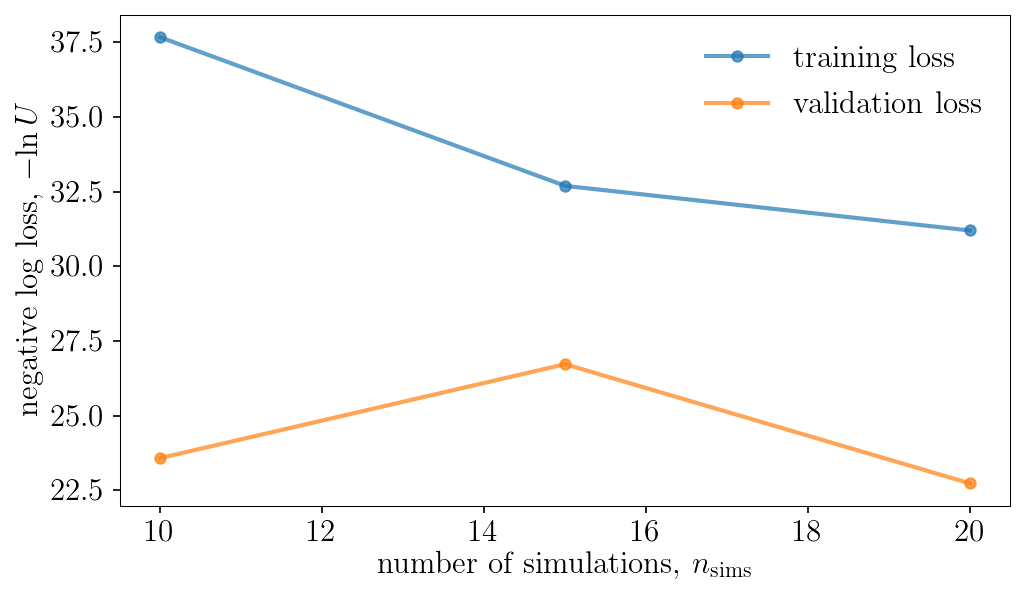

Population 4/10
Sampling proposal density...
Done.


0
1
2
3
total: 1.0270985349999933 s
0
1
2
3
total: 1.0260980689999997 s
0
1
2
3
total: 1.0220332569999755 s
0
1
2
3
total: 1.0248940640000228 s
0
1
2
3
total: 1.02355060900004 s


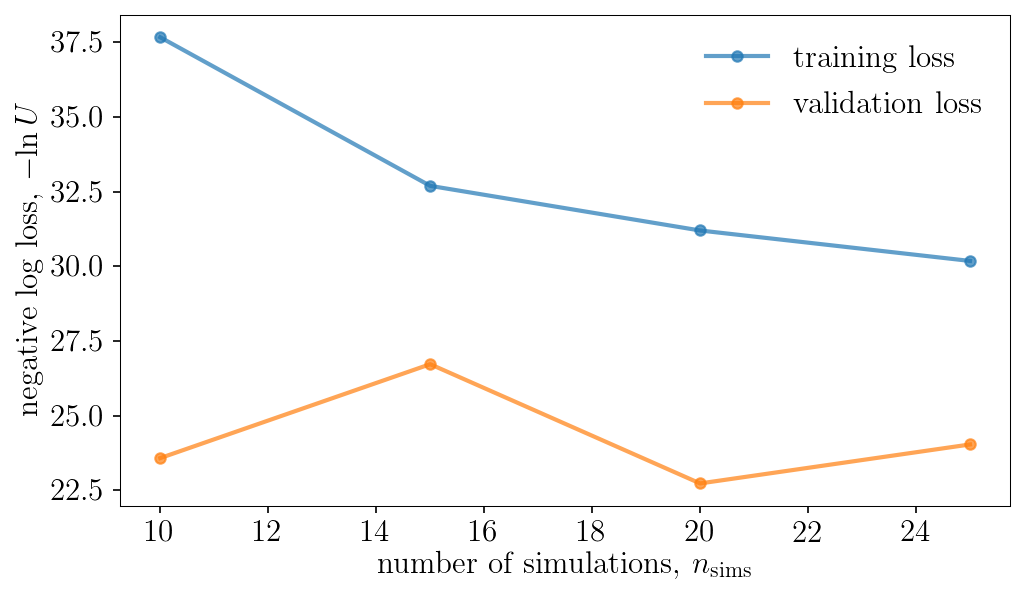

Population 5/10
Sampling proposal density...
Done.


0
1
2
3
total: 1.0297142900000154 s
0
1
2
3
total: 1.0181845870000643 s
0
1
2
3
total: 1.0219664500000363 s
0
1
2
3
total: 1.0157776680000552 s
0
1
2
3
total: 1.0260677950000172 s



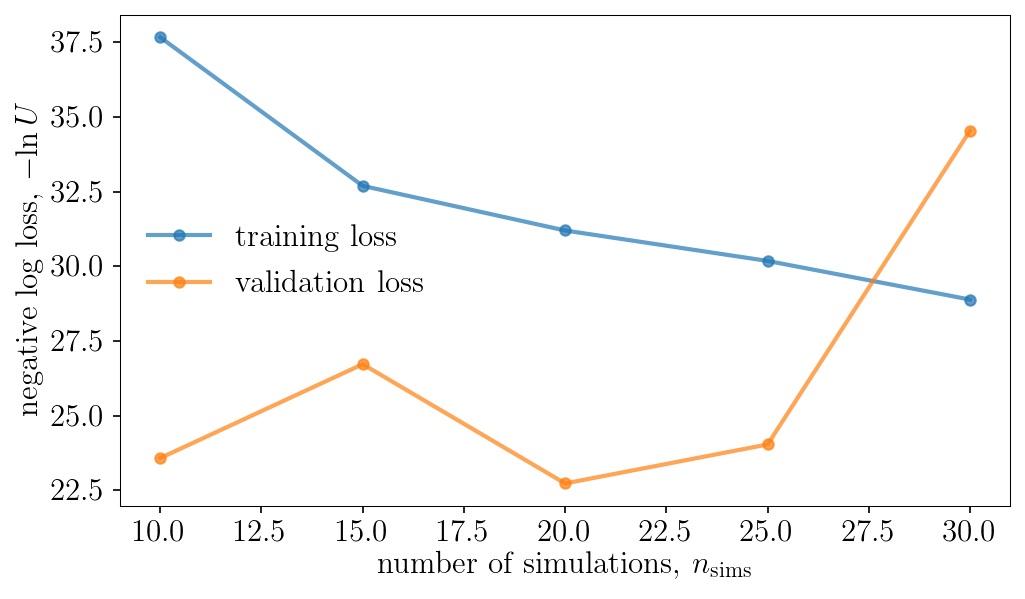

Population 6/10
Sampling proposal density...
Done.


0
1
2
3
total: 1.027340062999997 s
0
1
2
3
total: 1.0096426320000091 s
0
1
2
3
total: 1.021054184000036 s
0
1
2
3
total: 1.0120920219999334 s
0
1
2
3
total: 1.0191038440000284 s


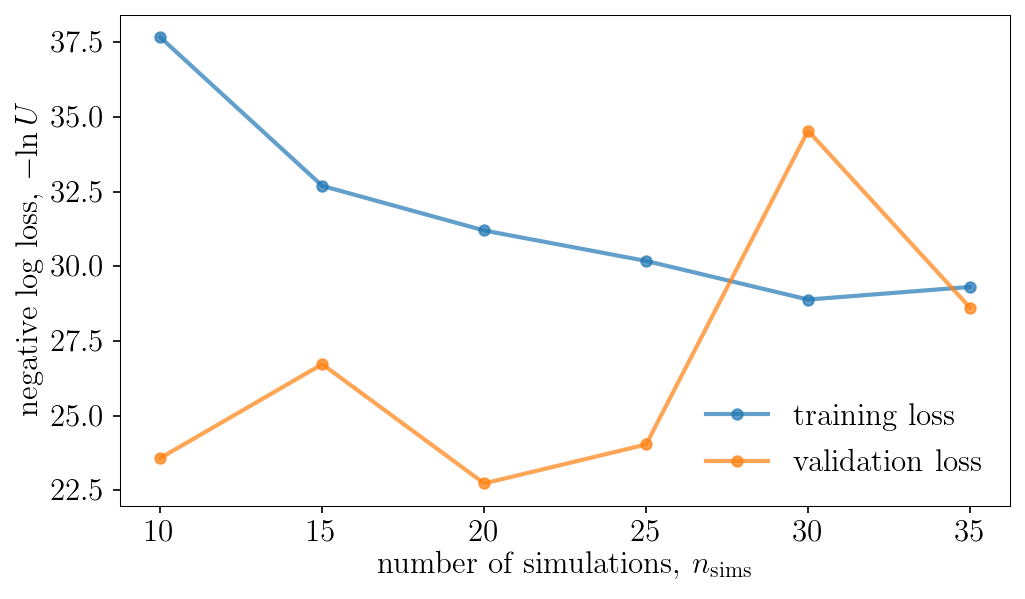

Population 7/10
Sampling proposal density...
Done.


0
1
2
3
total: 1.0201280080000288 s
0
1
2
3
total: 1.01135512999997 s
0
1
2
3
total: 1.0101326959999142 s
0
1
2
3
total: 1.0212697160000062 s
0
1
2
3
total: 1.0130656810000573 s


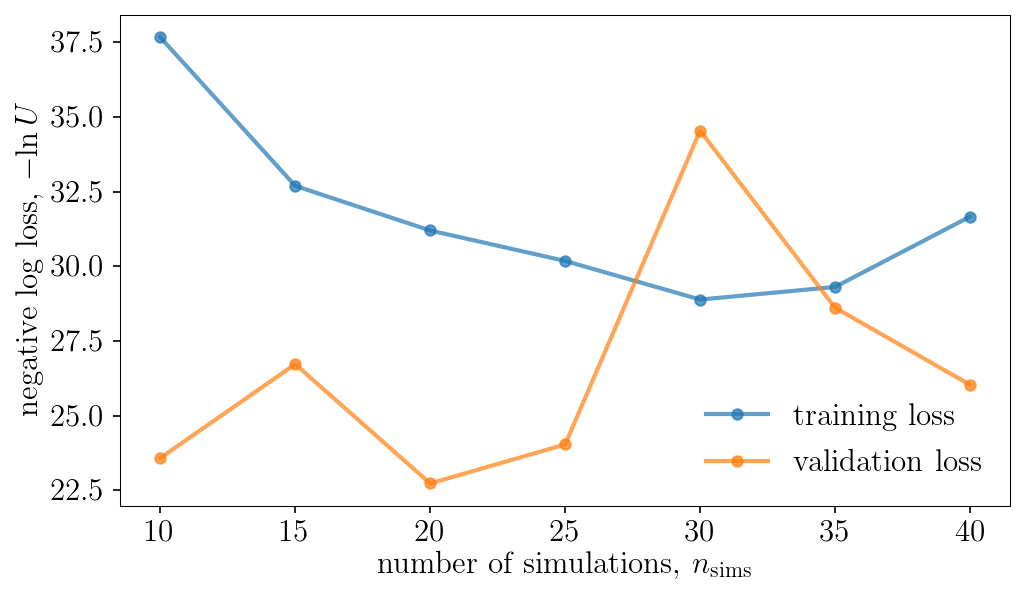

Population 8/10
Sampling proposal density...
Done.


0
1
2
3
total: 1.0138484450000078 s
0
1
2
3
total: 1.0122966889999816 s
0
1
2
3
total: 1.0218276310000647 s
0
1
2
3
total: 1.0082460459999538 s
0
1
2
3
total: 1.0120904519999385 s


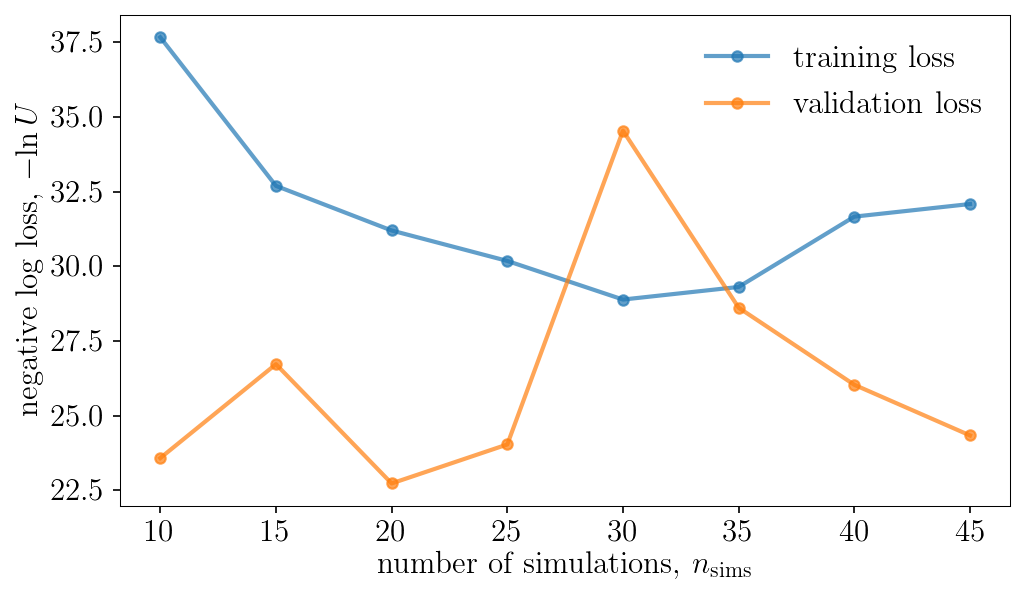

Population 9/10
Sampling proposal density...
Done.


0
1
2
3
total: 1.0221133680000776 s
0
1
2
3
total: 1.018451196000001 s
0
1
2
3
total: 1.0063817589999644 s
0
1
2
3
total: 1.0314677670000947 s
0
1
2
3
total: 1.0027647769999248 s



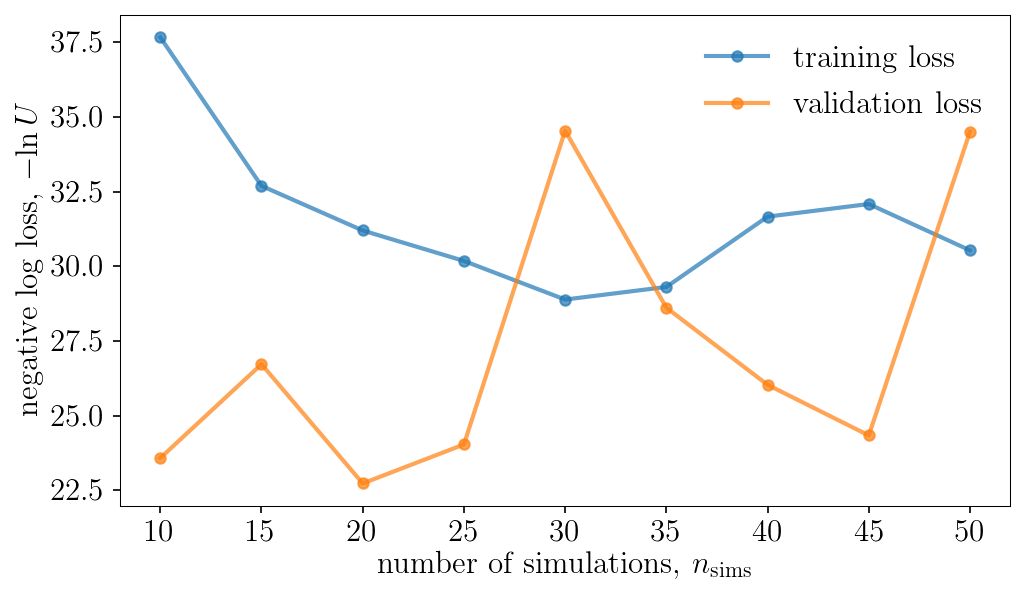

Population 10/10
Sampling proposal density...
Done.


0
1
2
3
total: 1.0189680549999593 s
0
1
2
3
total: 1.0088014929999645 s
0
1
2
3
total: 1.0082148120000056 s
0
1
2
3
total: 1.0157643719999214 s
0
1
2
3
total: 1.0174611470001764 s


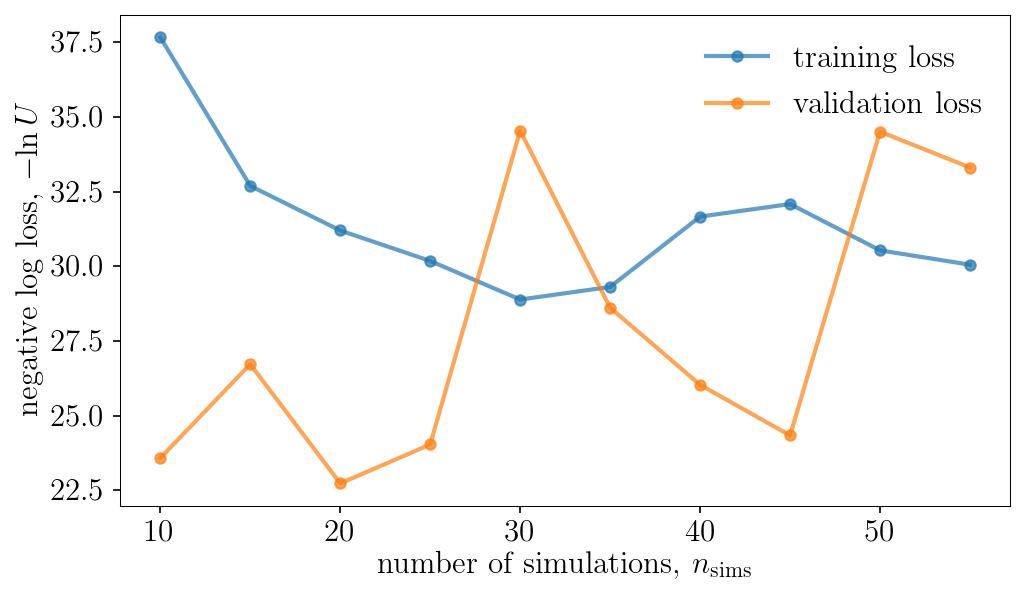

In [33]:
DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20, 
                                  save_intermediate_posteriors=False)

## Sample the learned posterior

In [34]:
x0 = DelfiEnsemble.posterior_samples[np.random.choice(np.arange(len(DelfiEnsemble.posterior_samples)), p=DelfiEnsemble.posterior_weights.astype(np.float32)/sum(DelfiEnsemble.posterior_weights), replace=False, size=DelfiEnsemble.nwalkers),:]
posterior_samples, posterior_weights, log_prob = DelfiEnsemble.emcee_sample(x0=x0)

## Alright let's plot it!
Feed it a list of `(n_samples, n_parameters)` arrays for making a triangle plot; in this case let's just plot the posterior samples.

Removed no burn in


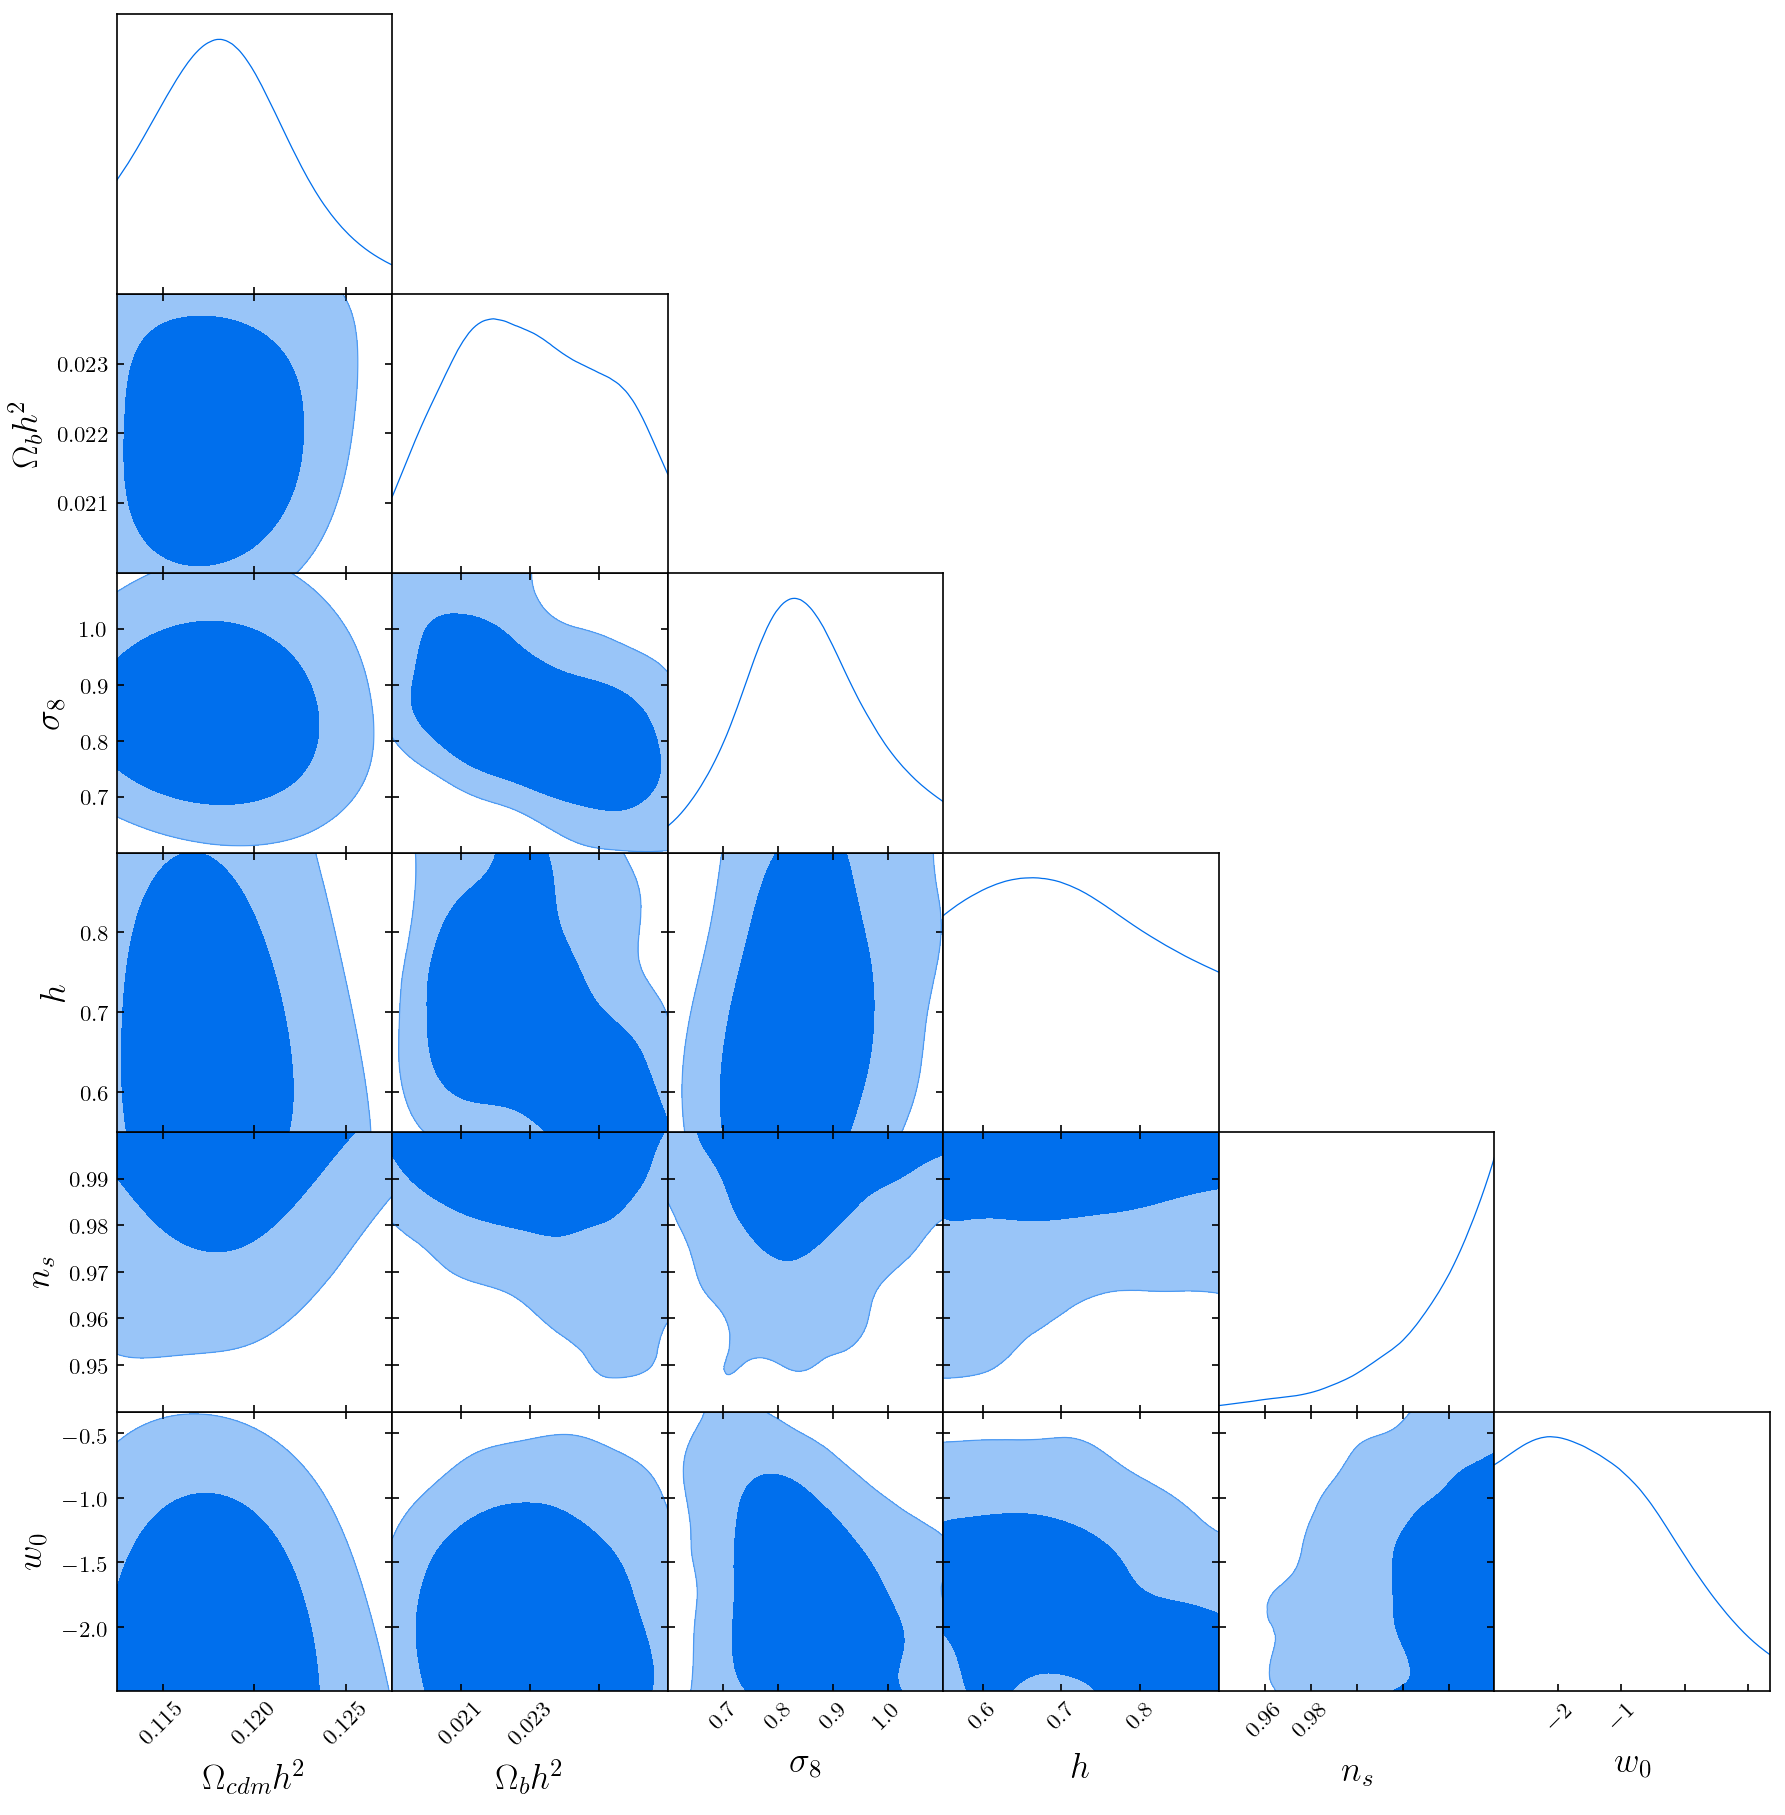

In [35]:
DelfiEnsemble.triangle_plot(samples=[posterior_samples], weights=[posterior_weights])